In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *

import numpy as np
import pandas as pd

import pytraj as pt
import mdtraj as md

import pickle
import os
import sys

import random

from collections import Counter

from glob import glob

import free_energy_clustering as FEC

## References and trajectories

Load the reference open and closed crystal structures. Note that 6 versions of the closed form are loaded, they are identical but with rotating chain IDs so that it doesn't matter how open structure closes, the minimum RMSD value will be retained.

In [2]:
rf0=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot0.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7')

rf1=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot1.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7')

rf2=pt.load('../1-Trajectories/0-Parm_rst//closed6_dry_rot2.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7')

rf3=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot3.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7')

rf4=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot4.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7')

rf5=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot5.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7')

rfopen=pt.load('../1-Trajectories/0-Parm_rst/open10_dry.rst7',
               '../1-Trajectories/0-Parm_rst/open10_dry.parm7')

The trajectories are then listed

In [3]:
indir1 = '../1-Trajectories/2-NoEq_with_IPA'
indir2 = '../1-Trajectories/4-Adaptive_sampling_with_IPA'
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'

traj_list1 = sorted(glob(indir1+'/*.nc'))
traj_list2 = sorted(glob(indir2+'/*.nc'))

traj_list=traj_list1+traj_list2
traj_list

['../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_01.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_02.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_03.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_04.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_05.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_06.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_07.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_08.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_09.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_10.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_01.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_02.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_03.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_04.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_05.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_06.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_07.nc',
 '../1-Traj

## GMM construction with limited dataset

First the GMM is built using uncorrelated data. We assume the data to be uncorrelated for a frame every 500 ps (dt=5)

The trajectory is therefore first loaded with a stride of 5

In [4]:
traj = pt.iterload(traj_list, topfile, stride=5)

The RMSD is then calculated. Because of the symmerty and chain IDs, 6 references are used for the closed form (simply corresponding to a rotation of the chain IDs), and the minimum RMSD is retained

In [12]:
rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")

rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)

rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")

We construct a array Z with the RMSD to the closed form and to the open form for each frame of the reduced trajectory

In [13]:
Z=[]
for i in range(0,len(rmsd_open)):
    a=np.array([rmsd_closed[i],rmsd_open[i]])
    Z.append(a)
Z=np.array(Z)

This is then pickled

In [5]:
# with open('./pickled/1-With_IPA/Z_dt5.pickle', 'wb') as outf:
#     pickle.dump(Z, outf)

To load the Z matrix from the pickled file:

In [ ]:
with open('./pickled/1-With_IPA/Z_dt5.pickle', 'rb') as inf:
    Z = pickle.load(inf)

We need to find the optimum number of components for constructing the GMM so we screen for a window of 2 to 20 components.

In [14]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=10, max_n_components=25, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=20, n_grids=151, n_splits=1,stack_landscapes=False)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 20
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 10
   max_n_components = 25
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 10
# Components = 11
# Components = 12
# Components = 13
# Components = 14
# Components = 15
# Components = 16
# Components = 17
# Components = 18
# Components = 19
# Components = 20
# Components = 21
# Components = 22
# Components = 23
# Components = 24
# Components = 25
Identifying final model with 13 components.
Evaluating density in landscape
Density grid shape: [151, 151]


The optimum number of components is 13, so we build and save a GMM with that many components

In [6]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=13, max_n_components=13, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=20, n_grids=151, n_splits=1,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 20
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 13
   max_n_components = 13
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*


The FEL points and energies are computed

In [28]:
coords, FE_landscape, FE_points = fec.landscape()

Estimating density with GMM.
# Components = 13
Identifying final model with 13 components.
Evaluating density in landscape
Density grid shape: [151, 151]


The FEL points and energies are then pickled 

In [7]:
# with open('./pickled/1-With_IPA/coords_dt5.pickle', 'wb') as outf:
#     pickle.dump(coords, outf)
# with open('./pickled/1-With_IPA/FE_landscape_dt5.pickle', 'wb') as outf:
#     pickle.dump(FE_landscape, outf)
# with open('./pickled/1-With_IPA/FE_points_dt5.pickle', 'wb') as outf:
#     pickle.dump(FE_points, outf)

To load the pickled files:

In [ ]:
with open('./pickled/1-With_IPA/coords_dt5.pickle', 'rb') as inf:
    coords = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_landscape_dt5.pickle', 'rb') as inf:
    FE_landscape = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_points_dt5.pickle', 'rb') as inf:
    FE_points = pickle.load(inf)

fec.FE_points_ = np.copy(FE_points)
fec.FE_landscape_ = np.copy(FE_landscape)
fec.coords_ = coords   

We can then plot the FES

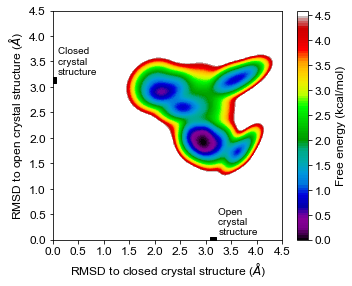

In [10]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=False, 
              figsize= [5, 5], transition_point_size=1, core_point_size=5, core_point_edgecolor='k', 
              colormap2='spectral',clust_point_edgecolor='w', clust_point_facecolor='', 
              clust_point_size=5, clust_point_linewidth=4, clust_point_marker='s',legend=None,
              extend=None, rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
              filename='./plots/1-With_IPA/1-FES_with_IPA_dt5', ax=None)

## Clustering for the limited dataset

In [33]:
labels, cluster_centers = fec.cluster(coords, FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 8206.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [122181  24709  45493  10946 158475]


Pickling of the clustering results:

In [9]:
# with open('./pickled/1-With_IPA/labels_dt5.pickle', 'wb') as outf:
#     pickle.dump(labels, outf)
# with open('./pickled/1-With_IPA/cluster_centers_dt5.pickle', 'wb') as outf:
#     pickle.dump(cluster_centers, outf)
    
with open('./pickled/1-With_IPA/labels_dt5.pickle', 'rb') as inf:
    labels=pickle.load(inf)
with open('./pickled/1-With_IPA/cluster_centers_dt5.pickle', 'rb') as inf:
    cluster_centers=pickle.load(inf)
    
fec.labels_ = np.copy(labels)
fec.cluster_centers_ = np.copy(cluster_centers)

Cluster centers and membership

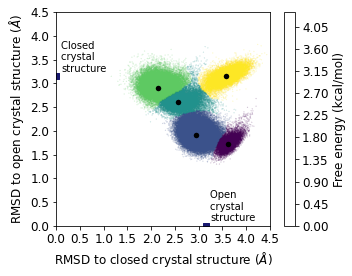

In [13]:
fec.pathways_ = None
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.05, core_point_edgecolor=None, 
              colormap2='viridis',clust_point_edgecolor=None, clust_point_facecolor='k', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5', ax=None)

Cluster centres on FES

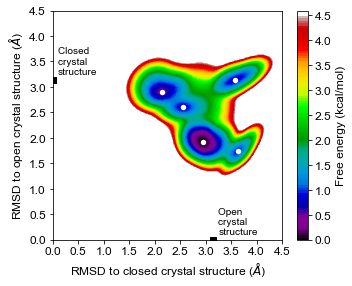

In [12]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.0, core_point_edgecolor='k', 
              colormap2='jet',clust_point_edgecolor='k', clust_point_facecolor='w', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=1,rmsd_point_color='k',
              filename='./plots/1-With_IPA/3-FES_with_IPA_with_cluster_centres_dt5', ax=None)

To use a blue colour code:

In [14]:
hexlist=[]

cmap = cm.get_cmap("Reds", 7)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexlist.append(matplotlib.colors.rgb2hex(rgb))
# sns.set_palette(hexlist)
# sns.palplot(sns.color_palette())

my_cmap_ipa=ListedColormap([hexlist[6],hexlist[5],hexlist[3],hexlist[2],hexlist[4]])

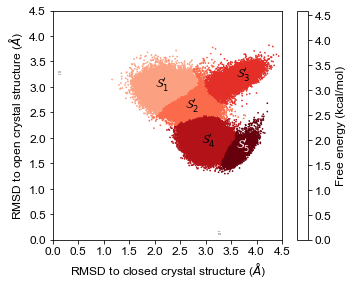

In [15]:
fec.pathways_ = None
fig, ax = plt.subplots()
fec.visualize(fontsize=12, savefig=False, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.25, core_point_edgecolor=None, 
              colormap2=my_cmap_ipa,clust_point_edgecolor=None, clust_point_facecolor=None, 
              clust_point_size=0, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=0, rmsd_point_fontsize=0, dx=1,
              core_point_alpha=1, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5', ax=ax, core_point_marker='o')


ax.text(2,3,r"$\mathcal{S}_1'$",c='k',fontsize=12)
ax.text(2.6,2.6,r"$\mathcal{S}_2'$",c='k',fontsize=12)
ax.text(3.6,3.2,r"$\mathcal{S}_3'$",c='k',fontsize=12)
ax.text(2.9,1.9,r"$\mathcal{S}_4'$",c='k',fontsize=12)
ax.text(3.6,1.8,r"$\mathcal{S}_5'$",c='w',fontsize=12 )

fig.savefig('./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5.png', dpi=600)

We can then look at the population of each state for the limited dataset

In [29]:
# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)
state_populations*100

array([ 5.97096519, 51.68863512,  0.        ,  6.89424771, 23.99319687,
       11.45295511])

Note that the population of states and simply counting the conformation in each cluster doesn't return the same. See InfleCS paper to see how density of state (which should be used to evaluate the population of each state) is calculated.

In [31]:
count=Counter(fec.labels_)
for i in range(1,len(count)+1):
    print(i,count[i]/len(fec.labels_)*100,'%')

1 5.494564729134849 %
2 50.46267181744677 %
3 10.767526128230468 %
4 22.269337885185518 %
5 11.005899440002395 %


## Assigning clusters to the full dataset

We can then assign to the predifined clusters to the complete dataset. 

First we load the complete trajectories, generate the Z matrix and pickled it

In [32]:
traj_all = pt.iterload(traj_list, topfile, stride=1)

In [28]:
rmsd0=pt.rmsd(traj_all,ref=rf0, mask="@CA,N,C,O")
rmsd1=pt.rmsd(traj_all,ref=rf1, mask="@CA,N,C,O")
rmsd2=pt.rmsd(traj_all,ref=rf2, mask="@CA,N,C,O")
rmsd3=pt.rmsd(traj_all,ref=rf3, mask="@CA,N,C,O")
rmsd4=pt.rmsd(traj_all,ref=rf4, mask="@CA,N,C,O")
rmsd5=pt.rmsd(traj_all,ref=rf5, mask="@CA,N,C,O")

rmsd_closed_all=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)

rmsd_open_all=pt.rmsd(traj_all,ref=rfopen, mask="@CA,N,C,O")

In [29]:
Z_all=[]
for i in range(0,len(rmsd_open_all)):
    a=np.array([rmsd_closed_all[i],rmsd_open_all[i]])
    Z_all.append(a)
Z_all=np.array(Z_all)

In [2]:
# with open('./pickled/1-With_IPA/Z_dt1.pickle', 'wb') as outf:
#     pickle.dump(Z_all, outf)
    
with open('./pickled/1-With_IPA/Z_dt1.pickle', 'rb') as inf:
    Z_all = pickle.load(inf)

Then we can assign the points to each clusters and calculate the state populations for the whole dataset

In [38]:
labels_all = fec.evaluate_clustering(Z_all, assign_transition_points=True)

Assigning cluster labels based on precomputed density model clustering.
Assigning cluster indices to non-core cluster points.


In [34]:
# with open('./pickled/1-With_IPA/labels_all.pickle', 'wb') as outf:
#     pickle.dump(labels_all, outf)
    
with open('./pickled/1-With_IPA/labels_all.pickle', 'rb') as inf:
    labels_all=pickle.load(inf)
    
# fec.labels_all_ = np.copy(labels_all)

In [35]:
fec.labels_ = np.copy(labels_all)

In [41]:
# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)
state_populations*100

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([ 5.52115876, 54.42203919,  0.        ,  8.65095143, 17.65691565,
       13.74893496])

## FES for the full dataset

Now we compute the FES for the full dataset using the same parameters as for the reduced dataset

In [7]:
fec_all = FEC.FreeEnergyClustering(Z_all, min_n_components=13, max_n_components=13, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=5, n_grids=150, n_splits=1,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 5
   n_grids = 150
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 13
   max_n_components = 13
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*


In [ ]:
coords_all, FE_landscape_all, FE_points_all = fec_all.landscape()

In [37]:
# with open('./pickled/1-With_IPA/coords_dt1.pickle', 'wb') as outf:
#     pickle.dump(coords_all, outf)
# with open('./pickled/1-With_IPA/FE_landscape_dt1.pickle', 'wb') as outf:
#     pickle.dump(FE_landscape_all, outf)
# with open('./pickled/1-With_IPA/FE_points_dt1.pickle', 'wb') as outf:
#     pickle.dump(FE_points_all, outf)
    
with open('./pickled/1-With_IPA/coords_dt1.pickle', 'rb') as inf:
    coords_all = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_landscape_dt1.pickle', 'rb') as inf:
    FE_landscape_all = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_points_dt1.pickle', 'rb') as inf:
    FE_points_all = pickle.load(inf)

fec_all.FE_points_ = np.copy(FE_points_all)
fec_all.FE_landscape_ = np.copy(FE_landscape_all)
fec_all.coords_ = coords_all 

Ploting the FES:

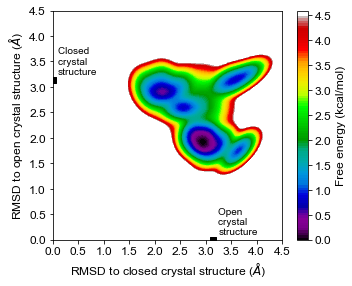

In [38]:
fec_all.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=False, 
              figsize= [5, 5], transition_point_size=1, core_point_size=5, core_point_edgecolor='k', 
              colormap2='spectral',clust_point_edgecolor='w', clust_point_facecolor='', 
              clust_point_size=5, clust_point_linewidth=4, clust_point_marker='s',legend=None,
              extend=None, rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
              filename='./plots/1-With_IPA/1-FES_with_IPA_dt1', ax=None)

In [39]:
fec_all.labels_ = np.copy(labels_all)

## the cluster centers are frame indexes so they are not valid here
# fec_all.cluster_centers_ = np.copy(cluster_centers)

Membership:

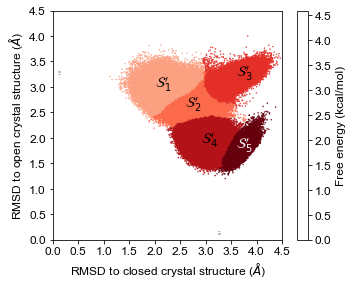

In [56]:
fec_all.pathways_ = None
fig, ax = plt.subplots()
fec_all.visualize(fontsize=12, savefig=False, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.25, core_point_edgecolor=None, 
              colormap2=my_cmap_ipa,clust_point_edgecolor=None, clust_point_facecolor=None, 
              clust_point_size=0, clust_point_linewidth=0, clust_point_marker='s',legend=None,
              extend='neither', rmsd_point_size=0, rmsd_point_fontsize=0, dx=1,
              core_point_alpha=1, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt1', ax=ax,core_point_marker='o')


ax.text(2,3,r"$\mathcal{S}_1'$",c='k',fontsize=14)
ax.text(2.6,2.6,r"$\mathcal{S}_2'$",c='k',fontsize=14)
ax.text(3.6,3.2,r"$\mathcal{S}_3'$",c='k',fontsize=14)
ax.text(2.9,1.9,r"$\mathcal{S}_4'$",c='k',fontsize=14)
ax.text(3.6,1.8,r"$\mathcal{S}_5'$",c='w',fontsize=14 )

fig.savefig('./plots/1-With_IPA/2-Cluster_map_with_IPA_dt1.png', dpi=600)

## Creating crisp clustering for extracting representative structures

Note that the GMM needs to be reconstructed form scratch running the following command, otherwise the clustering doesn't seem to work

In [42]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=13, max_n_components=13, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=20, n_grids=151, n_splits=1,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 20
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 13
   max_n_components = 13
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*


In [ ]:
coords, FE_landscape, FE_points = fec.landscape()

In [43]:
with open('./pickled/1-With_IPA/coords_dt5.pickle', 'rb') as inf:
    coords = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_landscape_dt5.pickle', 'rb') as inf:
    FE_landscape = pickle.load(inf)
with open('./pickled/1-With_IPA/FE_points_dt5.pickle', 'rb') as inf:
    FE_points = pickle.load(inf)

fec.FE_points_ = np.copy(FE_points)
fec.FE_landscape_ = np.copy(FE_landscape)
fec.coords_ = coords   

We redo the clustering but without assigning transition points. Note that this may not be required

In [120]:
labels, cluster_centers = fec.cluster(coords,FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 7984.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [121440  63960  15528  20772  73399]


In [44]:
# with open('./pickled/1-With_IPA/labels_dt5_crisp.pickle', 'wb') as outf:
#     pickle.dump(labels, outf)
# with open('./pickled/1-With_IPA/cluster_centers_dt5_crisp.pickle', 'wb') as outf:
#     pickle.dump(cluster_centers, outf)
    
with open('./pickled/1-With_IPA/labels_dt5_crisp.pickle', 'rb') as inf:
    labels=pickle.load(inf)
with open('./pickled/1-With_IPA/cluster_centers_dt5_crisp.pickle', 'rb') as inf:
    cluster_centers=pickle.load(inf)
    
fec.labels_ = np.copy(labels)
fec.cluster_centers_ = np.copy(cluster_centers)

In [121]:
state_populations = fec.population_states(n_sampled_points=10000)
state_populations

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([0.05473625, 0.54707884, 0.        , 0.08224617, 0.18321044,
       0.1327283 ])

In [134]:
from collections import Counter
Counter(labels)

Counter({4.0: 37309, 3.0: 17791, 5.0: 18430, 2.0: 84299, 1.0: 9136})

In [31]:
# Just in case
labels_old=labels
cluster_centers_old=cluster_centers

We use the following threshold (optained from a heuristic approach) to define the crisp clusters for i in [1,2,3,4,5] and threshold in [0.5,1,0.25,0.5,0.5]:

In [135]:
i=1
threshold=0.5
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [136]:
i=2
threshold=1
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [137]:
i=3
threshold=0.25
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [138]:
i=4
threshold=0.5
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

In [139]:
i=5
threshold=0.5
cluster_FE = FE_points[labels==i]
cluster_center_FE = FE_points[int(cluster_centers[i-1])]
diff_FE = cluster_FE-cluster_center_FE
new_labels = np.zeros(cluster_FE.shape[0])
new_labels[diff_FE< threshold] = i

labels[labels==i] = np.copy(new_labels)

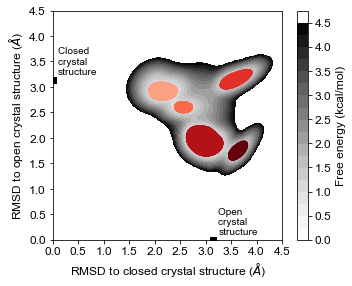

In [55]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
                  ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
                  vmax=4.5, colormap='Greys', lim=0.1, n_contour_levels=21, show_data=True, 
                  figsize= [5, 5], transition_point_size=0, core_point_size=0.25, 
                  core_point_edgecolor=None, 
                  colormap2=my_cmap_ipa,clust_point_edgecolor=None, clust_point_facecolor=None, 
                  clust_point_size=0, clust_point_linewidth=0, 
                  clust_point_marker='.',legend=None,
                  extend=None, rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
                  core_point_alpha=1, transition_point_alpha=0.0, surface_alpha=1,
                  filename='./plots/1-With_IPA/5-crisp_cluster_dt5_extended', 
                  ax=None, core_point_marker='o')

In [147]:
with open('./pickled/1-With_IPA/labels_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(labels, outf)
with open('./pickled/1-With_IPA/cluster_centers_dt5_crisp.pickle', 'wb') as outf:
    pickle.dump(cluster_centers, outf)
    
# with open('./pickled/1-With_IPA/labels_dt5_crisp.pickle', 'rb') as inf:
#     labels=pickle.load(inf)
# with open('./pickled/1-With_IPA/cluster_centers_dt5_crisp.pickle', 'rb') as inf:
#     cluster_centers=pickle.load(inf)
    
# fec.labels_ = np.copy(labels)
# fec.cluster_centers_ = np.copy(cluster_centers)

In [148]:
Counter(labels)

Counter({4.0: 20186, 0.0: 55191, 3.0: 5608, 5.0: 10903, 2.0: 69586, 1.0: 5491})

Note that `label==0` corresponds to the non-assigned transition points! The rest are the crisp clusters (from 1 to 5) in the same order than previoulsy

## Extracting representative structures

Need to first load trajectory in memory as the following `t[labels==i]` doesn't work with `pt.iterload`.

In [179]:
t = pt.load(traj_list, topfile, stride=5)

In [190]:
rf=[rf0,rf1,rf2,rf3,rf4,rf5]
toplist=sorted(glob('../1-Trajectories/0-Parm_rst/closed6_dry_rot*.parm7'))
toplist

['../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7',
 '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7']

In [196]:
sample_number=1000

for j in range(1,6):
    
    print("starting with", j)
    
    clust_traj = t[labels == j]
    print("Total number of frames:", clust_traj.n_frames)


    if clust_traj.n_frames > 0:
        
        randomlist = random.sample(range(0, clust_traj.n_frames), sample_number)
        tmp_traj=clust_traj[randomlist]
        print("Number of sampled frames:", tmp_traj.n_frames)
        
        if tmp_traj.n_frames > 0:

            new_traj = pt.Trajectory(top=topfile) # Empty trajectory
            min_ref=[]
    
            for i in range(0,tmp_traj.n_frames,1):

                rmsd0=pt.rmsd(tmp_traj[i:i+1],ref=rf0, mask="@CA,N,C,O")
                rmsd1=pt.rmsd(tmp_traj[i:i+1],ref=rf1, mask="@CA,N,C,O")
                rmsd2=pt.rmsd(tmp_traj[i:i+1],ref=rf2, mask="@CA,N,C,O")
                rmsd3=pt.rmsd(tmp_traj[i:i+1],ref=rf3, mask="@CA,N,C,O")
                rmsd4=pt.rmsd(tmp_traj[i:i+1],ref=rf4, mask="@CA,N,C,O")
                rmsd5=pt.rmsd(tmp_traj[i:i+1],ref=rf5, mask="@CA,N,C,O")

                rmsd_all=np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5])

                ali_struct=np.where(rmsd_all == np.nanmin(rmsd_all, axis=0))
                nb=int(ali_struct[0])
                new_frame=pt.align(tmp_traj[i:i+1],ref=rf[nb],mask="@CA,N,C,O", top=toplist[nb])
                new_traj.append(new_frame)
                min_ref.append(nb)

            new_traj.save('./sample_structures/1-With_IPA/1-Crisp_1000/ms{}.xtc'.format(j), overwrite=True)  

            print("Fraction original trajectories", float(new_traj.n_frames/tmp_traj.n_frames))

            with open('./sample_structures/1-With_IPA/1-Crisp_1000/ref_frame_ms{}.pickle'.format(j)
                      , 'wb') as outf:
                pickle.dump(min_ref, outf)
    print("finished with", j)
        


starting with 1
Total number of frames: 5491
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 1
starting with 2
Total number of frames: 69586
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 2
starting with 3
Total number of frames: 5608
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 3
starting with 4
Total number of frames: 20186
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 4
starting with 5
Total number of frames: 10903
Number of sampled frames: 1000
Fraction original trajectories 1.0
finished with 5
